# Composite priors

A common usecase is to have a multidimensional prior with different distributions in each dimension. We achieve this with scipy and torch distributions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import scipy.stats
import numpy as np

import pylab as plt

from toolz import compose
from swyft.prior import Prior, PriorTruncator
from swyft.utils import tensor_to_array, array_to_tensor

In [3]:
loc = torch.tensor([1.0, -3.2])
scale = torch.tensor([0.1, 2.1])

upper = torch.tensor([2.5, 3.1])
lower = torch.tensor([0.1, -2.0])

parameter_dimensions = [len(loc), len(upper)]
n_parameters = sum(parameter_dimensions)

## Torch Distributions

This requires the application of `Prior.conjugate_tensor_func` to convert the numpy arrays to tensors then the output tensors back to numpy arrays.

We apply `Prior.conjugate_tensor_func` with a functional idiom.

In [4]:
normal = torch.distributions.Normal(loc, scale)
uniform = torch.distributions.Uniform(lower, upper)

composite_prior_torch = Prior.composite_prior(
    cdfs=list(map(Prior.conjugate_tensor_func, [normal.cdf, uniform.cdf])),
    icdfs=list(map(Prior.conjugate_tensor_func, [normal.icdf, uniform.icdf])),
    log_probs=list(map(Prior.conjugate_tensor_func, [normal.log_prob, uniform.log_prob])),
    parameter_dimensions=parameter_dimensions,
)

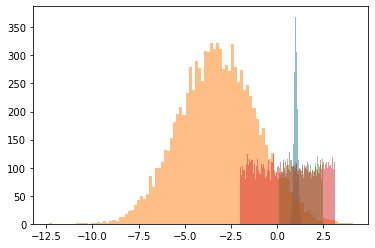

In [5]:
samples = PriorTruncator(composite_prior_torch, bound=None).sample(10_000)
for i in range(n_parameters):
    _ = plt.hist(samples[:, i], bins=100, alpha=0.5)

## SciPy Distributions

In [6]:
normal_scipy = scipy.stats.norm(loc, scale)
uniform_scipy = scipy.stats.uniform(lower, upper)

composite_prior_scipy = Prior.composite_prior(
    cdfs=list(map(Prior.conjugate_tensor_func, [normal_scipy.cdf, uniform_scipy.cdf])),
    icdfs=list(map(Prior.conjugate_tensor_func, [normal_scipy.ppf, uniform_scipy.ppf])),
    log_probs=list(map(Prior.conjugate_tensor_func, [normal_scipy.logpdf, uniform_scipy.logpdf])),
    parameter_dimensions=parameter_dimensions,
)

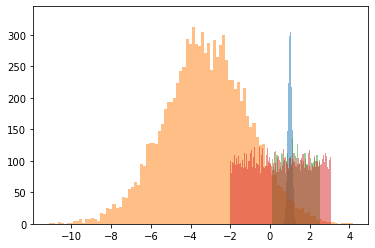

In [7]:
samples_scipy = PriorTruncator(composite_prior_torch, bound=None).sample(10_000)
for i in range(n_parameters):
    _ = plt.hist(samples_scipy[:, i], bins=100, alpha=0.5)